In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, mean_absolute_error

## Task Description
Predict drought level for the next 6 weeks, one prediction per week. Using 180 days of previous data.
## This notebook: baseline classifiers
* majority label based on various length past time windows (including using only 1 past data point)
* todo: predicting based on previous year's labels of the same date. Majority window label

In [131]:
#dftrain = pd.read_csv("train_timeseries.csv").set_index(['fips', 'date'])
dftest = pd.read_csv("test_timeseries.csv").set_index(['fips', 'date'])

In [6]:
dfval = pd.read_csv("validation_timeseries.csv").set_index(['fips', 'date'])

## majority label baseline

In [133]:
class MajorityLabel:
    def __init__(self, df):
        self.df = self.cleandf(df)
        self.true_labels = self.get_true_labels(self.df)
    
    def get_true_labels(self, df):
        dfclean = self.df
        fips_codes = np.unique(dfclean.index.get_level_values(0))
        true = {}
        for fips in fips_codes:
            subdf = dfclean.loc[fips]
            subdf.sort_index()
            for i in range(25, len(subdf) - 5): #easier to just have indices match for all window sizes (max win = 25)
                pred_date = subdf.iloc[i-1].name 
                true[(fips, pred_date)] = subdf.iloc[i:i+6].to_numpy().flatten()
        cols = ['w1', 'w2', 'w3', 'w4', 'w5','w6']
        dftrue = pd.DataFrame.from_dict(true, orient='index', 
                           columns=cols)
        return dftrue
    
    def cleandf(self, df):
        '''create df with only scores as ints and without nans. 
           indexes correspond to once a week score labels'''
        df = df[['score']].copy()
        df = df.dropna(axis=0)
        df = df.round().astype(int)
        return df
    '''
    def predict_optimized(self, window_size): #todo: integrate prev year labels later
        window size between 1 and 25
        dfclean = self.df
        fips_codes = np.unique(dfclean.index.get_level_values(0))
        data = {}
        #for fips in fips_codes:
        fips = 1001
        subdf = dfclean.loc[fips]

        # optimization of prediction
        counts = self.count_init(window_size, subdf)

        for i in range(25, len(subdf) - 5): # make all preds match indices
            # true labels are ints so can use to index
            pred_date = subdf.iloc[i-1].name 
            data[(fips, pred_date)] = np.argmax(counts) #don't need to make multiple cols because preds all same for w1-6
            if i == 25 + 47 or i == 25+48:
                print(counts)
            #update counts 
            counts[subdf.iloc[i - window_size][0]] -= 1 # first element in window
            counts[subdf.iloc[i + 1][0]] += 1 # next element outside window
                
        cols = ['pred']
        dfres = pd.DataFrame.from_dict(data, orient='index', 
                           columns=cols)
        return dfres
'''
    def predict(self, window_size): #todo: integrate prev year labels later
        '''window size between 1 and 25'''
        dfclean = self.df
        fips_codes = np.unique(dfclean.index.get_level_values(0))
        data = {}
        for fips in fips_codes:
            subdf = dfclean.loc[fips]

            for i in range(25, len(subdf) - 5): # make all preds match indices
                window = subdf.iloc[i - window_size : i]
                values, counts = np.unique(window, return_counts=True)# may not return same as pred because of tiebreaking
                maj = values[np.argmax(counts)]
                pred_date = window.iloc[-1].name 
                data[(fips, pred_date)] = maj #don't need to make multiple cols because preds all same for w1-6

        cols = ['pred']
        dfres = pd.DataFrame.from_dict(data, orient='index', 
                           columns=cols)
        return dfres
    
    
    def count_init(self, window_size, subdf): 
        counts = np.zeros(6)
        for i in range(25 - window_size, 25):
            counts[subdf.iloc[i][0]] += 1
        return counts

    def evaluate(self, dfres):
        # check indices match before evaluating
        dftrue = self.true_labels
        if not np.all(dfres.index == dftrue.index):
            print("index mismatch")
            return

        cols = ['w1', 'w2', 'w3', 'w4', 'w5','w6']
        f1 = 0
        mae = 0
        for col in cols:
            y = dftrue[[col]]
            y_pred = dfres # single column df because same pred for w1-w6
            f1 += f1_score(y, y_pred, average='macro').round(3)
            mae += mean_absolute_error(y, y_pred).round(3)
            
        return f1 / 6, mae / 6 # return average
        
    def do_all(self, window_size):
        return self.evaluate(self.predict(window_size))

In [135]:
maj = MajorityLabel(dftest)
res = []
windows = [25, 15, 5, 1]
for i in windows:
    res.append(maj.do_all(i))

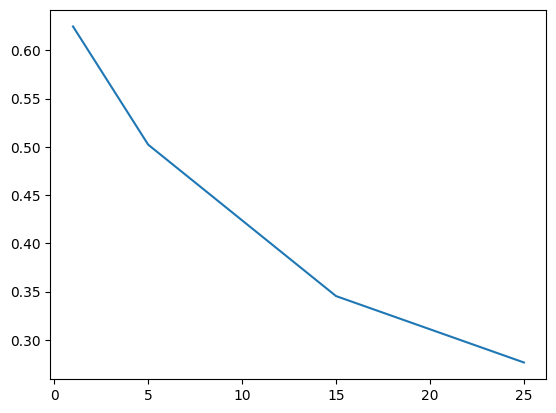

In [144]:
import matplotlib.pyplot as plt
windows = [25, 15, 5, 1]
f1s, maes = zip(*res)
plt.plot(windows, f1s)
plt.show()

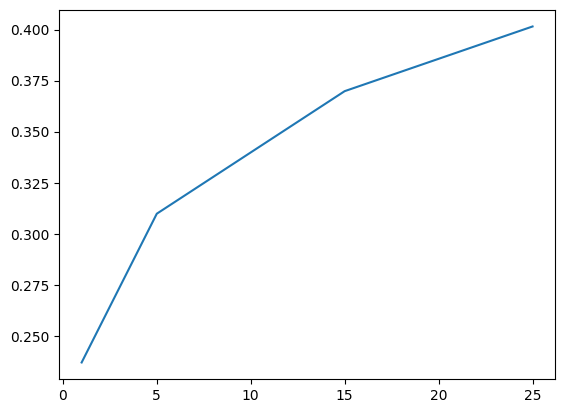

In [145]:
plt.plot(windows, maes)
plt.show()

f1 is worse on test set but MAE is better on test set?
 

# Todo
Use previous years prediction. maybe a rolling average?